# Relationships and default values

### Agenda: 
1. Modeling 1:1, 1:N, M:N relationships 
2. Default values, NULLs, and autoincrement
3. UUIDs 
4. Secondary unique keys

In [1]:
import datajoint as dj

In [2]:
schema = dj.Schema('dimitri_bank')

[2022-09-21 07:06:34,147][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-09-21 07:06:34,856][INFO]: Connected dimitri@db.ust-data-sci.net:3306


In [3]:
@schema
class Person(dj.Manual):
    definition = """
    person_id : int unsigned
    ---
    date_of_birth : date
    full_name : varchar(30)
    ssn : int
    """
    

In [4]:
import faker
fake = faker.Faker()

In [5]:
import random

In [6]:
Person.insert(
    dict(
        person_id = random.randint(100_000_000, 999_999_999),
        date_of_birth = fake.date_of_birth(),
        full_name = fake.name(),
        ssn = random.randint(100_00_0000, 999_99_9999)
    ) for _ in range(3000)
)

In [7]:
Person()

person_id,date_of_birth,full_name,ssn
100736996,1988-01-21,Ryan Carroll,693662313
101089368,1949-10-31,Rodney Larson,624997449
101179524,1914-11-28,Joshua Hendricks,989102464
101628159,1968-10-24,Joshua Grant,589612296
102215010,1977-04-27,Robert Becker,757141219
102429993,1986-10-16,Mark Brown,691647217
102697273,1955-12-06,Edward Jones,846903546
102872608,2020-03-18,Rachel Newton,696859337
102884207,1918-12-08,Nicole Goodwin,499530867
103149497,1931-01-16,Hannah Manning,692374987


In [8]:
@schema
class Account(dj.Manual):
    definition = """
    account : int unsigned 
    ---
    -> Person
    """

In [9]:
keys = Person.fetch("KEY")


In [10]:
random.choice(keys)

{'person_id': 591537366}

In [11]:
dict(random.choice(keys), account=10)

{'person_id': 953003224, 'account': 10}

In [12]:
Account.insert(
    dict(random.choice(keys), account=i) for i in range(300, 600))

In [13]:
Account()

account,person_id
558,104728015
420,105467497
366,123340380
384,127479809
511,128464454
523,129280391
594,135845005
567,137392646
555,140593584
365,143078002


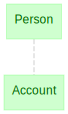

In [14]:
dj.Diagram(schema)

* A foreign key from Child to Parent creates a one-to-one relationship if the foreign key is also a unique index. 
* If the foreign key is not a unique index, then this becomes a many-to-one relationship.
* A single foreign key never creates a many-to-many relationship. For such relationships you need a separate *association table*.

### Modify the design so that each person could only have one account.
One person can only have one bank account.

In [15]:
@schema
class Person2(dj.Manual):
    definition = """
    person_id : int unsigned
    ---
    date_of_birth : date
    full_name : varchar(30)
    ssn : int
    """
    
@schema
class Account2(dj.Manual):
    definition = """
    -> Person2
    --- 
    balance : decimal(10, 2)
    """

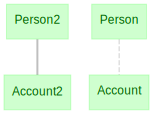

In [16]:
dj.Diagram(schema)

In [17]:
@schema
class Person3(dj.Manual):
    definition = """
    person_id : int unsigned
    ---
    date_of_birth : date
    full_name : varchar(30)
    ssn : int
    """
    
@schema
class Account3(dj.Manual):
    definition = """
    account : int
    --- 
    -> Person3
    balance : decimal(10, 2)
    unique index (person_id) 
    """

Here is how you would define Account3 in SQL:
```sql

CREATE TABLE account3 (
    account int NOT NULL,
    person_id int unsigned NOT NULL,
    balance decimal(10, 2) NOT NULL,
    PRIMARY KEY(account),
    FOREIGN KEY (person_id) REFERENCE person3(person_id),
    UNIQUE INDEX (person_id)
)
```

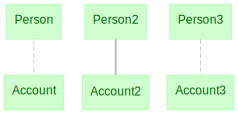

In [18]:
dj.Diagram(schema)

## Modify this design to allow multiple owners for each account

In [19]:
@schema
class Person4(dj.Manual):
    definition = """
    person_id : int unsigned
    ---
    date_of_birth : date
    full_name : varchar(30)
    ssn : int
    """
    
@schema
class Account4(dj.Manual):
    definition = """
    account : int unsigned
    --- 
    balance : decimal(10, 2)
    """
    
@schema
class AccountPerson4(dj.Manual):
    definition = """
    -> Person4
    -> Account4
    """

In [20]:
Person4.insert(
    dict(
        person_id = random.randint(100_000_000, 999_999_999),
        date_of_birth = fake.date_of_birth(),
        full_name = fake.name(),
        ssn = random.randint(100_00_0000, 999_99_9999)
    ) for _ in range(3000)
)

In [21]:
Account4.insert(
    dict(
        account = random.randint(100_000_000, 999_999_999),
        balance = random.randint(100_000_000, 999_999_999) / 100
    ) for _ in range(3000)
)

In [22]:
person_keys = Person4.fetch('KEY')
account_keys = Account4.fetch('KEY')

In [23]:
{**random.choice(person_keys), **random.choice(account_keys)}

{'person_id': 642100582, 'account': 665472440}

In [24]:
AccountPerson4.insert(
    ({**random.choice(person_keys), **random.choice(account_keys)}
    for _ in range(4000)),
    skip_duplicates=True
)

In [25]:
AccountPerson4()

person_id,account
100099454,943839668
100935914,181717356
100986864,142949824
101210981,341379745
101210981,466908323
101652587,294663607
101756491,241891345
102792954,667276575
102792954,725969106
102792954,748896047


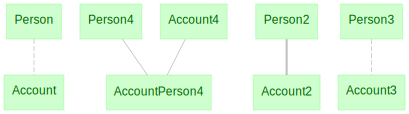

In [26]:
dj.Diagram(schema)

In [27]:
@schema
class Person5(dj.Manual):
    definition = """
    person_id : int unsigned
    ---
    date_of_birth : date
    full_name : varchar(30)
    ssn : int
    """
    
@schema
class Account5(dj.Manual):
    definition = """
    account : int unsigned
    --- 
    balance : decimal(10, 2)
    """
    
@schema
class AccountPerson5(dj.Manual):
    definition = """
    -> Account5
    ---
    -> Person5
    """

### translate `AccountPerson5` into SQL:
```sql
create table AccountPerson5 (
    account int unsigned NOT NULL,
    person_id int unsigned NOT NULL,
    PRIMARY KEY(account),
    FOREIGN KEY(account) REFERENCES Account5(account),
    FOREIGN KEY(person_id) REFERENCES Person5(person_id)
)
```

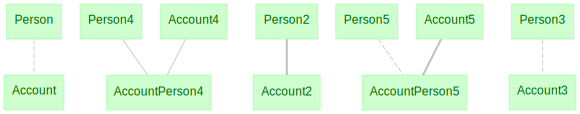

In [28]:
dj.Diagram(schema)

# Default values, nulls, and secondary indexes

In [29]:
@schema
class Person6(dj.Manual):
    definition = """
    person_id : int unsigned
    ---
    date_of_birth = null : date
    full_name = "": varchar(30)
    ssn = null : int
    unique index (ssn)
    """
    
@schema
class Account6(dj.Manual):
    definition = """
    account : int unsigned
    --- 
    -> [nullable] Person6
    balance = 0.0: decimal(10, 2)
    """

In [30]:
Person6.insert1(dict(person_id=1))

In [31]:
Person6.insert1(dict(person_id=2, full_name="Alice Cooper"))

In [32]:
Person6()

person_id,date_of_birth,full_name,ssn
1,None,,None
2,None,Alice Cooper,None


## Translate Person6 and Account6 into SQL 

```sql

CREATE TABLE Person6 (
    person_id int unsigned NOT NULL,
    date_of_birth date,
    full_name varchar(30) NOT NULL DEFAULT "", 
    ssn int,
    PRIMARY KEY(person_id),
    UNIQUE INDEX (ssn))

CREATE TABLE Account6 (
    account int unsigned NOT NULL auto_increment,
    person_id int unsigned,
    balance decimal(10, 2) NOT NULL DEFAULT 0.0, 
    PRIMARY KEY(account),
    FOREIGN KEY (person_id) REFERENCES Person6 (person_id) )
```